### [Kernel Ridge regression](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html#sklearn.kernel_ridge.KernelRidge)
- combines the Ridge technique (linear least squares with L2-norm regularization) with the [kernel trick](https://en.wikipedia.org/wiki/Kernel_method). 
- Learns a linear function in the space created by the respective kernel
- KRR uses a **squared error** loss.

### [Example: KRR vs SVR](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_kernel_ridge_regression.html)
- Both techniques model non-linear functions by using the "kernel trick"
- Use artificial (sinusoidal) dataset with noise added to every 5th point.
- Complexity and bandwidth of the RBF kernel are optimized via grid search.

In [1]:
import time
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve as LC
from sklearn.kernel_ridge import KernelRidge as KR
import matplotlib.pyplot as plt

In [2]:
rng     = np.random.RandomState(0)
X       = 5 * rng.rand(10000, 1)
y       = np.sin(X).ravel()
y[::5] += 3*(0.5-rng.rand(X.shape[0]//5)) # additional noise, every 5th point
X_plot  = np.linspace(0, 5, 100000)[:, None]

In [3]:
train_size = 100
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

kr = GridSearchCV(KR(kernel='rbf', gamma=0.1),
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)})

t0 = time.time()
svr.fit(X[:train_size], y[:train_size])
svr_fit = time.time() - t0
print("SVR complexity and bandwidth selected and model fitted in %.3f s"
      % svr_fit)

SVR complexity and bandwidth selected and model fitted in 0.245 s


In [4]:
t0 = time.time()
kr.fit(X[:train_size], y[:train_size])
kr_fit = time.time() - t0
print("KRR complexity and bandwidth selected and model fitted in %.3f s"
      % kr_fit)


KRR complexity and bandwidth selected and model fitted in 0.230 s


In [5]:
sv_ratio = svr.best_estimator_.support_.shape[0] / train_size
print("Support vector ratio: %.3f" % sv_ratio)

Support vector ratio: 0.320


In [6]:
t0 = time.time()
y_svr = svr.predict(X_plot)
svr_predict = time.time() - t0
print("SVR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], svr_predict))

SVR prediction for 100000 inputs in 0.054 s


In [7]:
t0 = time.time()
y_kr = kr.predict(X_plot)
kr_predict = time.time() - t0
print("KRR prediction for %d inputs in %.3f s"
      % (X_plot.shape[0], kr_predict))

KRR prediction for 100000 inputs in 0.084 s


<Figure size 640x480 with 0 Axes>

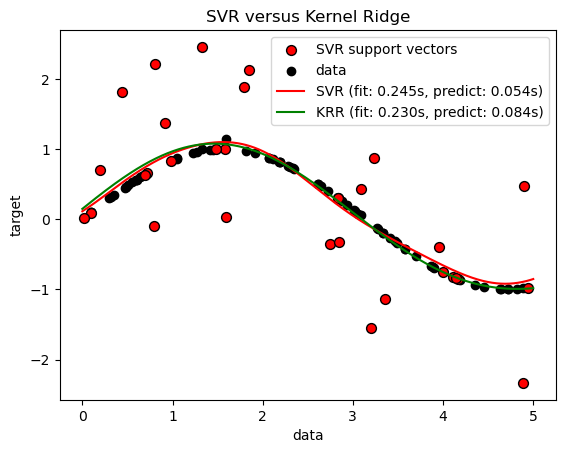

<Figure size 640x480 with 0 Axes>

In [8]:
sv_ind = svr.best_estimator_.support_

plt.scatter(X[sv_ind], y[sv_ind], 
            c='r', s=50, label='SVR support vectors',
            zorder=2, edgecolors=(0, 0, 0))
plt.scatter(X[:100], y[:100], 
            c='k', label='data', 
            zorder=1, edgecolors=(0, 0, 0))
plt.plot(   X_plot, y_svr, 
            c='r', label='SVR (fit: %.3fs, predict: %.3fs)' % (svr_fit, svr_predict))
plt.plot(   X_plot, y_kr, 
            c='g', label='KRR (fit: %.3fs, predict: %.3fs)' % (kr_fit, kr_predict))

plt.xlabel('data'); plt.ylabel('target')
plt.title('SVR versus Kernel Ridge'); plt.legend()
plt.figure()

### KRR vs SVR execution time for various training set sizes
- Using SVR to predict 1e+6 targets should be ~3X faster (sparse model learning with ~1/3 the training points).
- Not necessarily true - kernel function design details can make KRR just as faster or even faster.

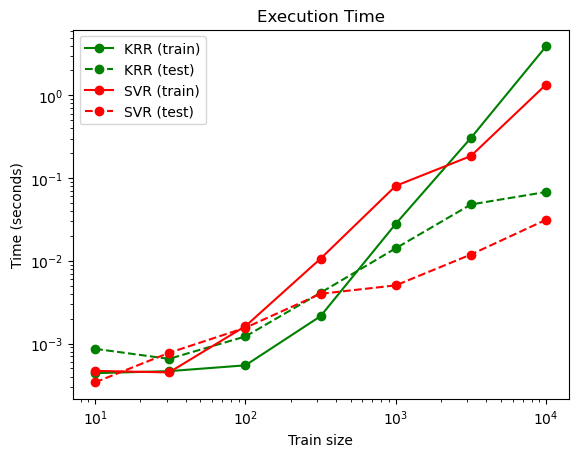

In [9]:
X       = 5*rng.rand(10000, 1)
y       = np.sin(X).ravel()
y[::5] += 3*(0.5-rng.rand(X.shape[0]//5))
sizes   = np.logspace(1, 4, 7).astype(int)

for name, estimator in {"KRR": KR(kernel='rbf', alpha=0.1, gamma=10),
                        "SVR": SVR(kernel='rbf', C=1e1, gamma=10)}.items():

    train_time, test_time = [],[]
    for train_test_size in sizes:
        t0 = time.time()
        estimator.fit(X[:train_test_size], y[:train_test_size])
        train_time.append(time.time() - t0)

        t0 = time.time()
        estimator.predict(X_plot[:1000])
        test_time.append(time.time() - t0)

    plt.plot(sizes, train_time, 'o-', color="r" if name == "SVR" else "g", label="%s (train)" % name)
    plt.plot(sizes, test_time, 'o--', color="r" if name == "SVR" else "g", label="%s (test)" % name)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Train size")
plt.ylabel("Time (seconds)")
plt.title('Execution Time')
plt.legend(loc="best")

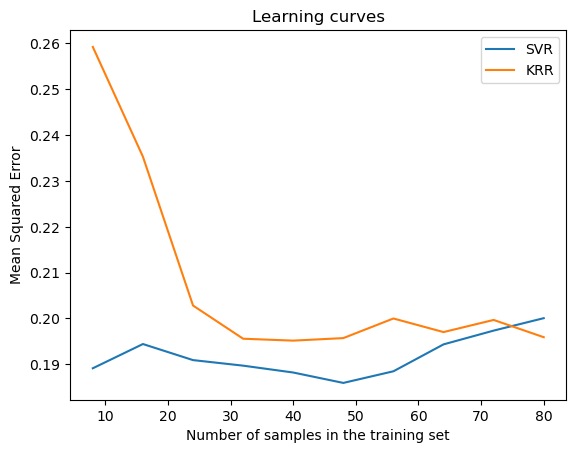

In [11]:
from sklearn.model_selection import LearningCurveDisplay

_, ax = plt.subplots()

svr = SVR(kernel="rbf", C=1e1, gamma=0.1)
kr = KR(kernel="rbf", alpha=0.1, gamma=0.1)

common_params = {
    "X": X[:100],
    "y": y[:100],
    "train_sizes": np.linspace(0.1, 1, 10),
    "scoring": "neg_mean_squared_error",
    "negate_score": True,
    "score_name": "Mean Squared Error",
    "score_type": "test",
    "std_display_style": None,
    "ax": ax,
}

LearningCurveDisplay.from_estimator(svr, **common_params)
LearningCurveDisplay.from_estimator(kr, **common_params)
ax.set_title("Learning curves")
ax.legend(handles=ax.get_legend_handles_labels()[0], labels=["SVR", "KRR"])

plt.show()